In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

/Users/matthew/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
batch_size = 32
img_height = 224
img_width = 224

In [3]:
TEST_DIR = 'vegetable-dataset/test'
TRAIN_DIR ='vegetable-dataset/train'
VALID_DIR ='vegetable-dataset/validation'

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,
                                                               seed=2509,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 15000 files belonging to 15 classes.


In [5]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(VALID_DIR,
                                                               seed=2509,
                                                               image_size=(img_height, img_width),
                                                               shuffle=False,
                                                               batch_size=batch_size)

Found 3000 files belonging to 15 classes.


In [6]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR,
                                                              seed=2509,
                                                              image_size=(img_height, img_width),
                                                              shuffle=False,
                                                              batch_size=batch_size)

Found 3000 files belonging to 15 classes.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


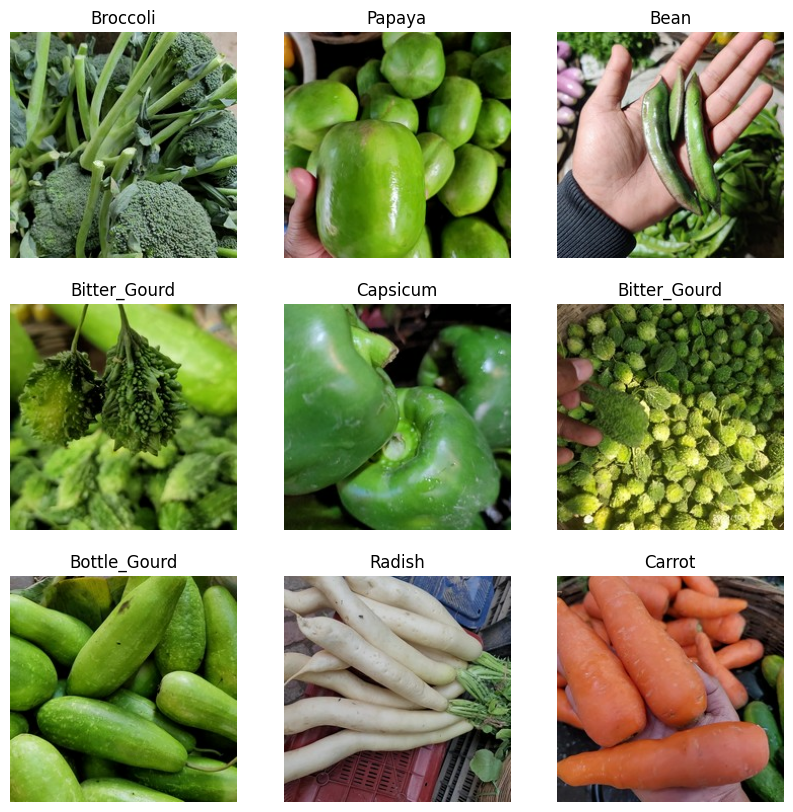

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [10]:
base_model.trainable = False

In [11]:
data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [12]:
inputs = tf.keras.Input(shape=(224,224,3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = base_model(x,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
x = tf.keras.layers.Dense(len(class_names),activation='softmax')(x)

In [13]:
model = tf.keras.Model(inputs=inputs, outputs=x, name="vegetable_Detection")

In [14]:
# Compile the model
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(lr=0.001),
    metrics = ["accuracy"])

In [15]:
model.summary()

Model: "vegetable_Detection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1280)      

In [16]:
initial_epochs = 5

In [17]:
# Fit the model
history = model.fit(x=train_ds,
                    epochs= initial_epochs,
                    validation_data=valid_ds)

Epoch 1/5


469/469 [==============================] - 151s 319ms/step - loss: 0.1371 - accuracy: 0.9583 - val_loss: 0.1073 - val_accuracy: 0.9663
Epoch 2/5
469/469 [==============================] - 160s 342ms/step - loss: 0.0551 - accuracy: 0.9829 - val_loss: 0.0142 - val_accuracy: 0.9960
Epoch 3/5
469/469 [==============================] - 148s 315ms/step - loss: 0.0383 - accuracy: 0.9893 - val_loss: 0.0242 - val_accuracy: 0.9927
Epoch 4/5
469/469 [==============================] - 151s 323ms/step - loss: 0.0342 - accuracy: 0.9907 - val_loss: 0.0277 - val_accuracy: 0.9923
Epoch 5/5
469/469 [==============================] - 150s 320ms/step - loss: 0.0360 - accuracy: 0.9913 - val_loss: 0.0127 - val_accuracy: 0.9960


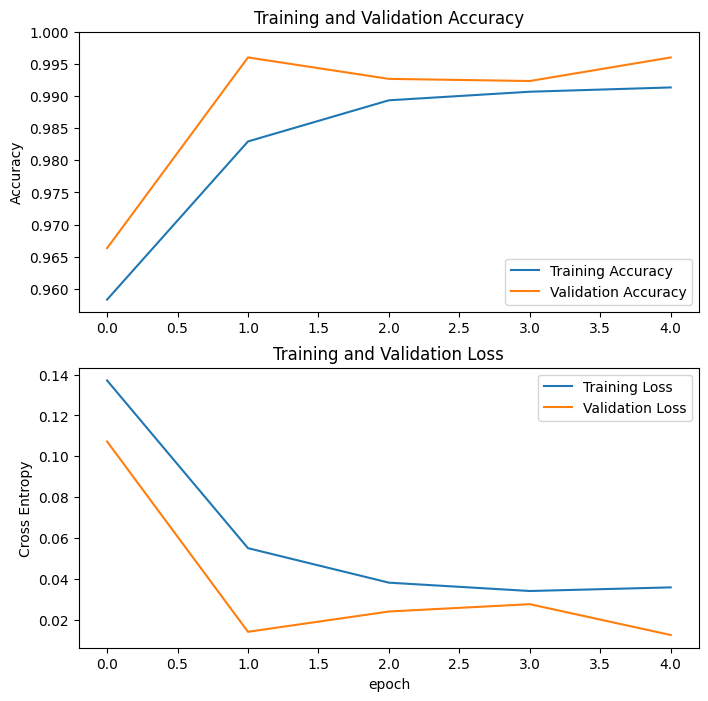

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
base_model.trainable = True

In [22]:
# Compile the model
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.legacy.Adam(1e-5),
    metrics = ["accuracy"])

In [23]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_ds)

Epoch 5/10


469/469 [==============================] - 521s 1s/step - loss: 0.0186 - accuracy: 0.9942 - val_loss: 0.0069 - val_accuracy: 0.9977
Epoch 6/10
469/469 [==============================] - 1970s 4s/step - loss: 0.0156 - accuracy: 0.9953 - val_loss: 0.0077 - val_accuracy: 0.9977
Epoch 7/10
469/469 [==============================] - 559s 1s/step - loss: 0.0048 - accuracy: 0.9985 - val_loss: 0.0186 - val_accuracy: 0.9940
Epoch 8/10
469/469 [==============================] - 621s 1s/step - loss: 0.0120 - accuracy: 0.9973 - val_loss: 0.0065 - val_accuracy: 0.9973
Epoch 9/10
469/469 [==============================] - 618s 1s/step - loss: 0.0083 - accuracy: 0.9973 - val_loss: 0.0042 - val_accuracy: 0.9987
Epoch 10/10
469/469 [==============================] - 561s 1s/step - loss: 0.0093 - accuracy: 0.9973 - val_loss: 0.0039 - val_accuracy: 0.9993


In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

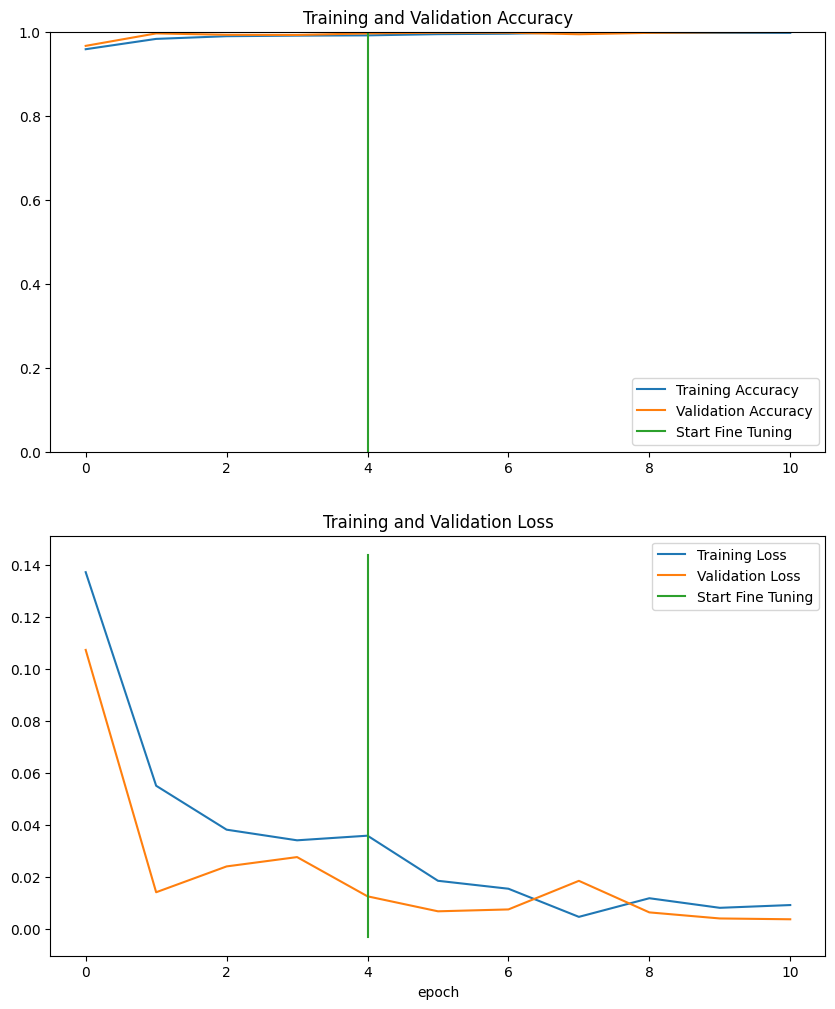

In [25]:
plt.figure(figsize=(10, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
# Make prediction on the validation data (not used to train on)
predictions = model.predict(valid_ds, verbose=1)

94/94 [==============================] - 20s 200ms/step


In [27]:
predictions.shape

(3000, 15)

In [28]:
np.sum(predictions[0])

1.0

In [29]:
predictions[0]

array([1.0000000e+00, 1.9453228e-08, 3.1155706e-10, 1.0294495e-11,
       2.3329051e-08, 3.6288203e-12, 9.0988772e-11, 7.1560396e-11,
       2.6022590e-13, 2.7035963e-08, 5.9137717e-09, 1.4548486e-13,
       2.4800732e-13, 1.9098392e-10, 3.7387329e-11], dtype=float32)

In [30]:
class_names[np.argmax(predictions[0])]

'Bean'

In [31]:
score = tf.nn.softmax(predictions[0])
score

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([0.16259336, 0.05981476, 0.05981476, 0.05981476, 0.05981476,
       0.05981476, 0.05981476, 0.05981476, 0.05981476, 0.05981476,
       0.05981476, 0.05981476, 0.05981476, 0.05981476, 0.05981476],
      dtype=float32)>

In [32]:
np.save('class_names.npy',class_names)

In [33]:
model.save("vegetable_detection")

INFO:tensorflow:Assets written to: vegetable_detection/assets


INFO:tensorflow:Assets written to: vegetable_detection/assets


In [34]:
model.evaluate(test_ds)

94/94 [==============================] - 20s 207ms/step - loss: 0.0068 - accuracy: 0.9980


[0.006827087607234716, 0.9980000257492065]

In [35]:
 model = tf.keras.models.load_model('vegetable_Detection')